In [1]:
import numpy as np
import os
import pandas as pd
import run_openpose
import re
import cv2
import matplotlib.pyplot as plt

In [2]:
!ls
img_show_flag = False

Photos                    depth_test_notebook.ipynb pose
__pycache__               openpose_depth_test.py    run_openpose.py


In [3]:
colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]

In [4]:
directory = os.path.join('.','photos')
filename = os.path.join(directory,'annotations.json')

In [5]:
data=pd.read_json(filename)

In [6]:
data = data.transpose().reset_index()[['filename','regions','size']]

In [7]:
protoFile = os.path.join('.','pose','coco','pose_deploy_linevec.prototxt')
weightsFile = os.path.join('.','pose','coco','pose_iter_440000.caffemodel')

In [8]:
dist_data=[]

In [9]:
for filename in os.listdir(directory):
    if filename.endswith('.jpg'):
        dist={'Filename': filename, 'Distance': int(re.search('%s(.*)%s' % ('_', 'm'), filename).group(1))}
        print(os.path.join(directory, filename))
        estimate = run_openpose.run_openpose(os.path.join(directory, filename),protoFile,weightsFile)
        f=data['filename']==filename
        d=data['regions'][[i for i, x in enumerate(f) if x][0]]
        for e_point in estimate:
            if e_point:
                idx = e_point[0][3]
                e_x = e_point[0][0]
                e_y = e_point[0][1]
                if (idx > 0) & (idx < 14):
                    if d[idx]['shape_attributes']:
                        x = d[idx]['shape_attributes']['cx']
                        y = d[idx]['shape_attributes']['cy']
                        dist[idx] = np.sqrt((e_x-x)**2+(e_y-y)**2)
        if img_show_flag:
            frameClone = cv2.imread(os.path.join(directory, filename))
            for e_point in estimate[1:14]:
                cv2.circle(frameClone, tuple(e_point[0][0:2]), 5, colors[e_point[0][3]], -1)
                aux = d[e_point[0][3]]['shape_attributes']
                cv2.circle(frameClone, (aux['cx'], aux['cy']), 5, colors[e_point[0][3]//10], -1)
            cv2.imshow("Keypoints",frameClone)
            cv2.waitKey(0)

        dist_data.append(dist)

./photos/D_3m_2.jpg
./photos/D_3m_1.jpg
./photos/M_4m_2.jpg
./photos/D_7m_2.jpg
./photos/M_4m_1.jpg
./photos/D_15m_1.jpg
./photos/D_7m_1.jpg
./photos/M_3m_1.jpg
./photos/D_4m_4.jpg
./photos/D_4m_5.jpg
./photos/D_4m_6.jpg
./photos/D_4m_2.jpg
./photos/M_15m_1.jpg
./photos/M_7m_2.jpg
./photos/D_4m_3.jpg
./photos/D_4m_1.jpg
./photos/M_15m_2.jpg
./photos/M_7m_1.jpg


In [10]:
dist_dataframe = pd.DataFrame(dist_data) 
dist_dataframe.sort_values(by=['Distance'])

,Filename,Distance,1,2,3,4,5,6,7,8,9,10,11,12,13
0,D_3m_2.jpg,3,78.873316,71.840100,15.620499,6.708204,30.675723,65.299311,47.853944,23.769729,58.000000,48.166378,42.047592,67.955868,58.240879
1,D_3m_1.jpg,3,34.828150,18.110770,42.544095,50.219518,67.675697,42.047592,37.215588,17.804494,54.378304,54.451814,46.043458,79.981248,58.180753
7,M_3m_1.jpg,3,35.383612,46.529560,54.203321,56.435804,51.244512,43.566042,68.249542,38.183766,34.785054,64.938432,40.804412,52.924474,20.615528
15,D_4m_1.jpg,4,44.944410,59.539903,51.894123,21.213203,57.384667,46.818800,56.462377,23.600847,7.071068,26.925824,13.416408,28.231188,26.683328
14,D_4m_3.jpg,4,19.235384,13.928388,10.440307,27.018512,45.694639,33.837849,12.206556,59.413803,31.827661,31.240999,50.695167,44.687806,44.553339
11,D_4m_2.jpg,4,15.132746,39.357337,66.370174,48.662100,35.846897,57.775427,50.000000,4.000000,13.038405,18.027756,7.810250,23.086793,28.600699
10,D_4m_6.jpg,4,37.107951,48.846699,35.383612,19.723083,28.425341,56.080300,48.600412,27.018512,36.878178,61.400326,41.000000,72.615425,40.199502
9,D_4m_5.jpg,4,NaN,96.628153,NaN,1388.703352,NaN,341.177373,NaN,221.677694,NaN,769.615488,NaN,435.900218,NaN
8,D_4m_4.jpg,4,16.401219,48.041649,30.083218,47.801674,50.219518,15.033296,10.295630,26.925824,9.486833,17.262677,10.770330,12.806248,11.180340
4,M_4m_1.jpg,4,55.470713,21.540659,41.400483,23.769729,30.805844,66.850580,31.240999,50.119856,62.425956,48.795492,47.381431,45.541190,51.000000


In [11]:
aux=np.array(dist_dataframe['Distance'])

In [12]:
distances = np.unique(aux)
mean_dist = 100000*np.ones(distances.shape)

for j,i in enumerate(distances):
    temp = np.array(dist_dataframe[dist_dataframe.columns[2:]][dist_dataframe['Distance']==i])
    mean_dist[j] = np.nanmean(temp)

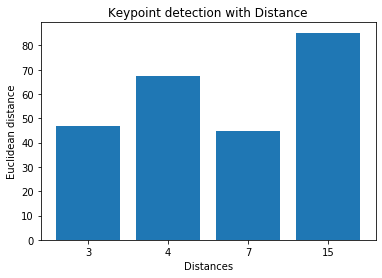

[46.8306945  67.36666107 44.93071268 85.24745647]


In [20]:
%matplotlib inline

index = np.arange(len(distances))
plt.bar(index, mean_dist)
plt.xlabel('Distances', fontsize=10)
plt.ylabel('Euclidean distance', fontsize=10)
plt.xticks(index, distances, fontsize=10, rotation=0)
plt.title('Keypoint detection with Distance')
plt.show()

print(mean_dist)